# Notes:

1. Initially "criterion = nn.CrossEntropyLoss()" that expects torch.long numbers to be parsed, but our 2nd mapping uses float numbers instead so now a Binary cross entropy function is used together with a sigmoid function to flatten the outputs between 0 and 1
2. Our BCE criterion also requires a sigmoid layer at the output to squash the output between 0 and 1 and also the unsqueeze(1) command so that the shape of our data and targets match the output (e.g torch.Size([ batch_size]) becomes              torch.Size([ batch_size,1])  )  reference: https://medium.com/analytics-vidhya/simple-neural-network-with-bceloss-for-binary-classification-for-a-custom-dataset-8d5c69ffffee


In [2]:
import sys, re
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms  
import torchvision
from torch.utils.data import (Dataset,DataLoader)
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import time
from sklearn.metrics import matthews_corrcoef

# Allergen dataset

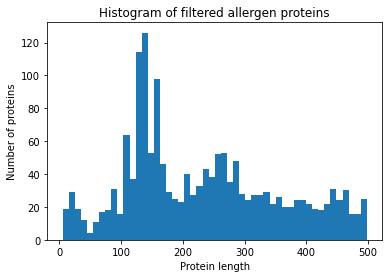

Total proteins left: 1654
Minimum length: 5
Maximum length: 498
Mean: 231.8186215235792
Median: 211.0
Mode: 134


In [3]:
#Define a class to  filter out  the unwanted proteins
def filter_fasta(input_file, output_file, min_length, max_length):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    filtered_proteins = []
    filtered_lengths = []

    current_protein = None
    current_sequence = []

    for line in lines:
        if line.startswith('>'):
            if current_protein is not None:
                sequence = ''.join(current_sequence)
                sequence_length = len(sequence)
                if min_length <= sequence_length <= max_length:
                    filtered_proteins.append(current_protein + '\n' + sequence)
                    filtered_lengths.append(sequence_length)
            current_protein = line.strip()
            current_sequence = []
        else:
            current_sequence.append(line.strip())

    # Check the last protein after the loop ends
    if current_protein is not None:
        sequence = ''.join(current_sequence)
        sequence_length = len(sequence)
        if min_length <= sequence_length <= max_length:
            filtered_proteins.append(current_protein + '\n' + sequence)
            filtered_lengths.append(sequence_length)

    with open(output_file, 'w') as f:
        f.write('\n'.join(filtered_proteins))

    # Calculate statistics
    total_proteins = len(filtered_proteins)
    min_length = min(filtered_lengths)
    max_length = max(filtered_lengths)
    mean = np.mean(filtered_lengths)
    median= np.median(filtered_lengths)
    mode = stats.mode(filtered_lengths)

    # Plot distribution
    plt.hist(filtered_lengths, bins=50)
    plt.xlabel('Protein length')
    plt.ylabel('Number of proteins')
    plt.title('Histogram of filtered allergen proteins')
    plt.show()

    return total_proteins, min_length, max_length, mean, median, mode

# Usage
total, minimum, maximum,mean,median,mode = filter_fasta('Allergen_Proteins.fasta', 'Filtered_Allergen_Proteins.fasta', 1, 500)
print("Total proteins left:", total)
print("Minimum length:", minimum)
print("Maximum length:", maximum)
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode[0][0])

In [4]:
def map_sequence(sequence, mapping):
    map = [mapping[aa] for aa in sequence if aa in mapping]
    return np.array(map)

def map_fasta(input_file, mapping):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    mapped_sequences = []

    current_protein_id = None
    current_sequence = ''
    for line in lines:
        if line.startswith('>'):
            if current_protein_id and current_sequence:
                mapped_sequence = map_sequence(current_sequence, mapping)
                mapped_sequences.append((current_protein_id, mapped_sequence))
            current_protein_id = line.strip()[1:]
            current_sequence = ''
        else:
            current_sequence += line.strip()

    # Process the last protein sequence
    if current_protein_id and current_sequence:
        mapped_sequence = map_sequence(current_sequence, mapping)
        mapped_sequences.append((current_protein_id, mapped_sequence))

    return mapped_sequences

# Mapping of amino acids to numbers
mapping = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
    'Y': 20, 'X': 0, 'Z': 0
}

# Input FASTA file path
input_file = 'Filtered_Allergen_Proteins.fasta'


mapped_sequences = map_fasta(input_file, mapping)

# Unkwown proteins

In [24]:
input_file = 'NOT_Allergen_Proteins.fasta'
output_file = 'Reduced_NOT_Allergen_Proteins.fasta'
selected = 5000


proteins = list(SeqIO.parse(input_file, 'fasta'))


selected_proteins = random.sample(proteins, selected)

# Write the selected protein records to the output file
SeqIO.write(selected_proteins, output_file, 'fasta')

print(f"Selected {selected} proteins and saved them as '{output_file}'.")

Selected 5000 proteins and saved them as 'Reduced_NOT_Allergen_Proteins.fasta'.


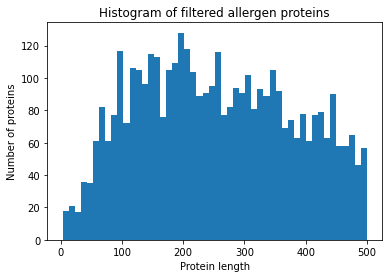

Total proteins left: 4007
Minimum length: 3
Maximum length: 500
Mean: 254.67431994010482
Median: 247.0
Mode: 198


In [25]:
# Usage
total, minimum, maximum, mean,median,mode = filter_fasta('Reduced_NOT_Allergen_Proteins.fasta', 'Filtered_NOT_Allergen_Proteins.fasta', 1,500)
print("Total proteins left:", total)
print("Minimum length:", minimum)
print("Maximum length:", maximum)
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode[0][0])

In [27]:
#convert amino acid sequences to numbers
def map_sequence(sequence, mapping):
    map = [mapping[aa] for aa in sequence if aa in mapping]
    return np.array(map)

def map_fasta(input_file, mapping):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    mapped_sequences = []

    current_protein_id = None
    current_sequence = ''
    for line in lines:
        if line.startswith('>'):
            if current_protein_id and current_sequence:
                mapped_sequence = map_sequence(current_sequence, mapping)
                mapped_sequences.append((current_protein_id, mapped_sequence))
            current_protein_id = line.strip()[1:]
            current_sequence = ''
        else:
            current_sequence += line.strip()

    # Process the last protein sequence
    if current_protein_id and current_sequence:
        mapped_sequence = map_sequence(current_sequence, mapping)
        mapped_sequences.append((current_protein_id, mapped_sequence))

    return mapped_sequences

# Mapping of amino acids to numbers
mapping = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
    'Y': 20, 'X': 0 , 'U': 0, 'B': 0, 'J': 0, 'O': 0,'Z':0
}

# Input FASTA file path
input_file = 'Filtered_NOT_Allergen_Proteins.fasta'


mapped_sequences = map_fasta(input_file, mapping)  

# Merge datasets

In [38]:
def sequence_padding(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        padding_length = max_length - len(seq)
        padded_seq = seq + "X" * padding_length  # Padding with a special token, "X"
        padded_sequences.append(padded_seq)
    return padded_sequences

allergen_sequences = []
allergen_headers = []

with open("Filtered_Allergen_Proteins.fasta", "r") as file:
    lines = file.readlines()

for line in lines:
    if line.startswith(">"):
        allergen_headers.append(line.strip())
    else:
        allergen_sequences.append(line.strip())
        
# Randomly select allergen proteins to increase the count up to 5000
while len(allergen_sequences) < 4000:
    random_protein = random.choice(allergen_sequences)
    allergen_sequences.append(random_protein)

non_allergen_sequences = []
non_allergen_headers = []

with open("Filtered_NOT_Allergen_Proteins.fasta", "r") as file:
    lines = file.readlines()

for line in lines:
    if line.startswith(">"):
        non_allergen_headers.append(line.strip())
    else:
        non_allergen_sequences.append(line.strip())

# Step 2: Create a merged dataset
merged_sequences = allergen_sequences + non_allergen_sequences
merged_labels = [1] * len(allergen_sequences) + [0] * len(non_allergen_sequences)

# Shuffle the protein order
merged_data = list(zip(merged_sequences, merged_labels))
random.shuffle(merged_data)
merged_sequences, merged_labels = zip(*merged_data)

# Step 3: Determine the maximum sequence length for padding
max_length = max(len(seq) for seq in merged_sequences)

# Step 4: Apply sequence padding
padded_sequences = sequence_padding(merged_sequences, max_length)

# Step 5: Save the merged dataset with padded sequences
with open("Proteins.fasta", "w") as file:
    for i in range(len(padded_sequences)):
        file.write("> Label:" + str(merged_labels[i]) + "\n")
        file.write(padded_sequences[i] + "\n")

# Print the total number of proteins
total_proteins = len(padded_sequences)
print("Total number of proteins:", total_proteins)


label_1 = sum(label == 1 for label in merged_labels)
label_0 = sum(label == 0 for label in merged_labels)

print("Total number of allergen proteins:", label_1)
print("Total number of non allergen proteins:", label_0)
print("Max length:",max_length)
# Print the first 5 proteins
print("First 5 proteins:")
for i in range(5):
    print("Label:", merged_labels[i])
    print("Sequence:", padded_sequences[i])
    print()

Total number of proteins: 8007
Total number of allergen proteins: 4000
Total number of non allergen proteins: 4007
Max length: 500
First 5 proteins:
Label: 0
Sequence: MPFLVALSGIISGVRDHSMTVRLDQQTRQRLQDIVKGGYRSANAAIVDAINKRWEALHDEQLDAAYAAAIHDNPAYPYESEAERSAARARRNARQQRSAQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Label: 1
Sequence: MVKEFNTQTELSVRLEALWAVLSKDFITVVPKVLPHIVKDVQLIEGDGGVGTILIFNFLPEVSPSYQREEITEFDESSHEIGLQVIEGGYLSQGLSYYKTTFKLSEIEEDKTLVNVKISYDHDSDIEEKVTPTKTSQSTLMYLRRLERYLSNGSAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [39]:
################################################################################################################################

#Create a class that takes the encoded sequences and labels to split later for train,val and test
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]

        
        sequence_tensor = torch.tensor(sequence, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        return sequence_tensor, label_tensor

    
################################################################################################################################

################################################################################################################################
# Load the merged dataset with padded sequences and verify it works by printing the first sequence
merged_sequences = []
merged_labels = []

with open("Proteins.fasta", "r") as file:
    lines = file.readlines()

for i in range(0, len(lines),2):
    sequence = lines[i+1].strip() #check every odd line and strip any whitespace
    label = int(lines[i].split(":")[1]) #check every even line
    merged_sequences.append(sequence)
    merged_labels.append(label)
    
for i in range(1):
    print(f"Label {i+1}: {merged_labels[i]}")
    print(f"Sequence {i+1}: {merged_sequences[i]}")
    print()

################################################################################################################################
#Map sequences to numbers again and save the file
mapping= {
    'A': -0.21, 'C': -6.04, 'D': 1.36, 'E': 2.3, 'F': -4.65, 'G': 0, 'H': -1.23,
    'I': -4.81, 'K': 3.88, 'L': -4.68, 'M': -3.66, 'N': 0.96, 'P': 0.75, 'Q': 1.52,
    'R': 2.11, 'S': 1.74, 'T': 0.78, 'V': -3.5, 'W': -3.32, 'Y': -1.01,
    'X': 0, 'U': 0, 'B': 0, 'J': 0, 'O': 0, 'Z': 0
}

# Convert all sequences to numerical arrays using the custom mapping
# Assuming you have already loaded the merged_sequences list and defined the custom mapping

# Convert all sequences to numerical arrays using the custom mapping
mapped_sequences = []
for sequence in merged_sequences:
    mapped_sequence = [mapping[aa] for aa in sequence]
    mapped_sequences.append(mapped_sequence)

print("Total number of sequences:" ,len(mapped_sequences))
print("First mapped sequence:",mapped_sequences[0])
print("Length of each sequence:", len(mapped_sequences[0]))
print(len(merged_labels))


# Save the numerical sequences and labels to a new fasta-like file with numerical representations
output_file = "Mapped.fasta"
with open(output_file, "w") as file:
    for i, (mapped_sequence, label) in enumerate(zip(mapped_sequences, merged_labels)):
        file.write(f"Label: {label}\n")
        file.write("Sequence: ")
        file.write(" ".join(map(str, mapped_sequence)))  
        file.write("\n")

print(f"Numeric sequences and labels saved to {output_file}")

Label 1: 0
Sequence 1: MPFLVALSGIISGVRDHSMTVRLDQQTRQRLQDIVKGGYRSANAAIVDAINKRWEALHDEQLDAAYAAAIHDNPAYPYESEAERSAARARRNARQQRSAQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Total number of sequences: 8007
First mapped sequence: [-3.66, 0.75, -4.65, -4.68, -3.5, -0.21, -4.68, 1.74, 0, -4.81, -4.81, 1.74, 0, -3.5, 2.11, 1.36, -1.23, 1.74, -3.66, 0.78, -3.5, 2.11, -4.68, 1.36, 1.52, 1.52, 0.78, 2.11, 1.52, 2.11, -4.68, 1.52, 1.36, -4.81, -3.5, 3.88, 0, 0, -1.01, 2.11, 1.74, -0.21, 0.96, -0.21, -0.21, -4.81, -3.5, 1.36, -0.21, -4.81, 0.96, 3.88, 2.11, -3.32, 2.3, -0.21, -4.68, -1.23, 1.36, 2.3, 1.52, -4.68, 1.36, -0.21, -0.21, -1.01, -0.21, -0.

In [40]:
with open("Mapped.fasta", "r") as file:
    lines = file.readlines()

dataset = ProteinDataset(mapped_sequences, merged_labels)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for batch processing
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

print('Train dataset size:', len(train_dataset)) 
print('Validation dataset size:', len(val_dataset)) 
print('Test dataset size:', len(test_dataset))

for sequence_tensor, label_tensor in train_loader:
    print("Sample Sequence Tensor:")
    print(sequence_tensor[0])  # Printing the first tensor in the batch
    print("Tensor shape:",sequence_tensor[0].shape)
    print("First label tensor:",label_tensor[0])

    break  # Stop after printing one batch to avoid excessive output

Train dataset size: 6405
Validation dataset size: 800
Test dataset size: 802
Sample Sequence Tensor:
tensor([-3.6600,  2.3000, -4.8100,  0.0000,  0.0000, -4.6800, -3.5000, -1.0100,
        -4.6800, -3.5000, -4.8100, -3.5000, -3.5000, -0.2100, -4.8100, -4.8100,
        -1.2300,  1.7400,  1.7400,  1.5200,  0.0000, -3.5000,  1.3600, -1.0100,
        -6.0400,  3.8800, -4.8100,  2.1100, -6.0400,  0.7500,  1.7400,  0.0000,
        -4.8100, -1.2300,  0.7800, -3.5000, -6.0400,  1.5200, -1.0100,  0.0000,
         2.3000,  1.7400,  0.7800,  3.8800,  0.7500,  1.7400,  3.8800,  0.9600,
        -6.0400, -0.2100,  0.0000,  3.8800, -3.5000, -4.8100,  3.8800,  1.7400,
        -3.5000,  0.0000,  0.7500,  0.7800,  2.3000,  2.3000,  2.3000,  3.8800,
         3.8800, -4.6800, -4.8100, -3.5000,  1.7400,  2.3000, -1.2300,  0.9600,
         2.1100, -4.6500,  2.1100,  1.5200,  3.8800, -3.5000, -0.2100,  1.5200,
         0.0000, -4.6800,  2.3000,  0.7800,  2.1100,  0.0000,  0.9600,  0.7500,
         0.0000,  0

In [41]:
class ConvNet(nn.Module):
    def __init__(self, input_length=500,classes=1):
        super(ConvNet, self).__init__()
        
        #First layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        #Second layer
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5,padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        #Third layer
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5,padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(128*(input_length-4), 256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(256, classes)
        
     

    def forward(self, input):
        # Apply the convolutional layers
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.dropout1(output)

 

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.dropout2(output)

 

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.dropout3(output)
        
        output = output.view(output.size(0), -1)
        
        output = self.fc1(output)
        output = self.relu4(output)
        output = self.dropout4(output)
        output = self.fc2(output)
        
        # Apply sigmoid activation to the output of the last fully connected layer
        output = torch.sigmoid(output)
        return output



In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)

# Loss and optimizer functions
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.BCELoss()

# 4. Train the Model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sequence_tensor, label_tensor in train_loader:
        sequence_tensor, label_tensor = sequence_tensor.to(device), label_tensor.to(device)

        optimizer.zero_grad()

        outputs = model(sequence_tensor.unsqueeze(1))  # Add a channel dimension for Conv1d
        loss = criterion(outputs, label_tensor.unsqueeze(1))  # Add a channel dimension for BCELoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
    
def evaluate_model(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
    all_predicted_labels = []  # Initialize the list
    all_true_labels = []  # Initialize the list

    with torch.no_grad():
        for sequence_tensor, label_tensor in data_loader:
            sequence_tensor, label_tensor = sequence_tensor.to(device), label_tensor.to(device)

            outputs = model(sequence_tensor.unsqueeze(1))
            predicted_labels = outputs >= 0.5

            correct_predictions += (predicted_labels == label_tensor.unsqueeze(1)).sum().item()
            total_samples += label_tensor.size(0)

            # Calculate true positives, true negatives, false positives, and false negatives for this batch
            true_positives += ((predicted_labels == 1) & (label_tensor.unsqueeze(1) == 1)).sum().item()
            true_negatives += ((predicted_labels == 0) & (label_tensor.unsqueeze(1) == 0)).sum().item()
            false_positives += ((predicted_labels == 1) & (label_tensor.unsqueeze(1) == 0)).sum().item()
            false_negatives += ((predicted_labels == 0) & (label_tensor.unsqueeze(1) == 1)).sum().item()

            # Calculate MCC for this batch and store the predicted and true labels
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(label_tensor.unsqueeze(1).cpu().numpy())

    accuracy = correct_predictions / total_samples

    # Calculate Matthews Correlation Coefficient (MCC) using scikit-learn
    mcc = matthews_corrcoef(all_true_labels, all_predicted_labels)

    return accuracy, mcc


# Evaluate on the validation set
val_accuracy, val_mcc = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_accuracy}, Validation MCC: {val_mcc}")

# Evaluate on the test set
test_accuracy, test_mcc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy}, Test MCC: {test_mcc}")

Epoch 1/10, Loss: 2.602489080795875
Epoch 2/10, Loss: 0.5270415439055516
Epoch 3/10, Loss: 0.4690387106858767
Epoch 4/10, Loss: 0.4158904355305892
Epoch 5/10, Loss: 0.349886289697427
Epoch 6/10, Loss: 0.3186469362332271
Epoch 7/10, Loss: 0.2640031266670961
Epoch 8/10, Loss: 0.24255441083357884
Epoch 9/10, Loss: 0.20016167301398058
Epoch 10/10, Loss: 0.18026011609114134
Validation Accuracy: 0.87625, Validation MCC: 0.7531219989904653
Test Accuracy: 0.8678304239401496, Test MCC: 0.7357530806873664
